# Image Classification of Flowers

The goal of this project is to classify flowers. The dataset used is the [Oxford_flower102](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/).

The project is broken down into the following steps:

- Load and prepare image dataset.
- Build and Train an image classifier on this dataset.
- Use the trained model to make predictions on the validation set of images.

In [1]:
#importing all libraries needed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pathlib, glob
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

from PIL import Image

print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))
print('Libraries Imported')


Num GPUs Available:  1
Libraries Imported


## Load and Prepare Dataset

1. Load Dataset
2. Create image and label lists
3. Standarize images
4. Organize images in test, validation and train sets


In [2]:
#importing dataset images
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)


In [3]:
#counting total number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [4]:
#searching for all folders (labels) inside dataset
obj = os.scandir(data_dir)

print("Files and Directories in '% s':" % data_dir)

label_names = []
for folder in obj :
    if folder.is_dir():
        label_names.append(folder.name)

print(label_names)


Files and Directories in 'C:\Users\luisa\.keras\datasets\flower_photos':
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [5]:
image_list = []
image_labels_list = []
dim = (100, 100)

#selecting every image inside for each folder (label)
for i in range(len(label_names)):
    paths = list(data_dir.glob(label_names[i] + '/*'))
    for path in paths: #saving image in a list and the label in another list ensuring same length
        image_labels_list.append(label_names[i]) 
        prov_img = Image.open(path)
        prov_img = prov_img.resize(dim) #resizing images to square 100x100 size
        image_list.append(np.asarray(prov_img)) #saving images as array
        
#normalizing images
image_labels_array = np.array(image_labels_list)
image_array = np.array(image_list)/255.0


In [6]:
#inspecting arrays
image_labels_array.shape, image_array.shape


((3670,), (3670, 100, 100, 3))

In [7]:
#printing label names and respective image count
print(Counter(image_labels_array).keys()) # equals to list(set(words))
print(Counter(image_labels_array).values()) # counts the elements' frequency


dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
dict_values([633, 898, 641, 699, 799])


In [8]:
#splitting dataset to test and train; #splitting test data in half for testing and validation
X_train, X_test, y_train, y_test = train_test_split(image_array, image_labels_array, test_size = 0.30, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state=42)


In [9]:
#ensuring the test, validation and train shape is correct
X_test.shape, X_val.shape, X_train.shape


((550, 100, 100, 3), (551, 100, 100, 3), (2569, 100, 100, 3))

In [10]:
#preparing labels data
def prepare_labels(y_train, y_test, y_val):
    #creating labels dataframe
    df_y_train = pd.DataFrame({'Train Labels':y_train})
    df_y_test = pd.DataFrame({'Test Labels':y_test})
    df_y_val = pd.DataFrame({'Validation Labels':y_val})
    #performing One Hot Encoding
    ohe_style = OneHotEncoder()
    #train
    ohe_train = ohe_style.fit_transform(df_y_train)
    df_ohe_train=pd.DataFrame(ohe_train.toarray(), columns=ohe_style.categories_)
    array_ohe_train=df_ohe_train.to_numpy()
    #test
    ohe_test = ohe_style.fit_transform(df_y_test)
    df_ohe_test=pd.DataFrame(ohe_test.toarray(), columns=ohe_style.categories_)
    array_ohe_test=df_ohe_test.to_numpy()
    #val
    ohe_val = ohe_style.fit_transform(df_y_val)
    df_ohe_val=pd.DataFrame(ohe_val.toarray(), columns=ohe_style.categories_)
    array_ohe_val=df_ohe_val.to_numpy()
    return array_ohe_train,array_ohe_test,array_ohe_val

array_ohe_train, array_ohe_test, array_ohe_val = prepare_labels(y_train, y_test,y_val)


## Create Model

In [11]:
#starting model
model = tf.keras.Sequential()

    #add convolution filters
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
    #choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
    #randomly turn neurons on and off
model.add(Dropout(0.25))
    #flatten for a classification output
model.add(Flatten())
    #get all relevant data
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
    #output probabilities, 5 different answers (labels)
model.add(Dense(5, activation='softmax'))


In [12]:
#defining optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=5e-4)

#compiling model
model.compile(loss='categorical_crossentropy', 
                   optimizer=opt,
                   metrics=['accuracy'])

#inspecting model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 141376)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

## Train Model

In [13]:
#training model
if tf.config.list_physical_devices('GPU'):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min') #setting early stop
    history = model.fit(x=X_train, y=array_ohe_train, epochs = 100,
                        validation_data = (X_val, array_ohe_val),
                        callbacks = [early_stopping],
                       workers=-1)

else:
    history = model.fit(X_train, asd, epochs=5)

print("Training completed")

Epoch 1/100
81/81 [==============================] - 7s 26ms/step - loss: 1.4945 - accuracy: 0.3928 - val_loss: 1.1662 - val_accuracy: 0.5082
Epoch 2/100
81/81 [==============================] - 2s 19ms/step - loss: 1.1683 - accuracy: 0.5123 - val_loss: 1.1104 - val_accuracy: 0.5172
Epoch 3/100
81/81 [==============================] - 2s 19ms/step - loss: 1.0468 - accuracy: 0.5761 - val_loss: 1.0100 - val_accuracy: 0.5989
Epoch 4/100
81/81 [==============================] - 1s 18ms/step - loss: 0.8709 - accuracy: 0.6672 - val_loss: 0.9497 - val_accuracy: 0.6243
Epoch 5/100
81/81 [==============================] - 2s 19ms/step - loss: 0.7279 - accuracy: 0.7322 - val_loss: 1.0165 - val_accuracy: 0.6225
Epoch 6/100
81/81 [==============================] - 1s 18ms/step - loss: 0.5868 - accuracy: 0.7886 - val_loss: 1.0846 - val_accuracy: 0.5989
Epoch 7/100
81/81 [==============================] - 2s 19ms/step - loss: 0.4448 - accuracy: 0.8494 - val_loss: 1.0122 - val_accuracy: 0.6388
Epoch 

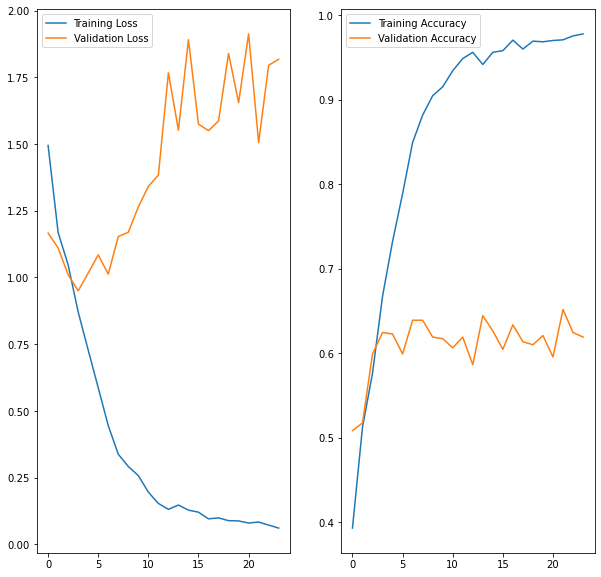

In [14]:
#plotting training results
fig, plpl = plt.subplots(ncols=2, figsize=(10,10))
plpl[0].plot(history.history['loss'], label='Training Loss')
plpl[0].plot(history.history['val_loss'], label = 'Validation Loss')
plpl[0].legend()

plpl[1].plot(history.history['accuracy'], label='Training Accuracy')
plpl[1].plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plpl[1].legend()
plt.show()


In [15]:
#testing model
test_loss, test_acc = model.evaluate(X_test, array_ohe_test)
print('Test accuracy:', test_acc)


18/18 [==============================] - 0s 10ms/step - loss: 2.0387 - accuracy: 0.6127
Test accuracy: 0.6127272844314575


## Save Model

In [17]:
# #creating directory and saving model
import datetime
train_date = datetime.date.today().strftime("%Y_%h_%d")
model.save('saved_model/my_model---'+train_date)


INFO:tensorflow:Assets written to: saved_model/my_model---2021_Nov_01-00_00\assets
